<center>
<img src="https://supportvectors.ai/logo-poster-transparent.png" width="400px" style="opacity:0.7">
</center>

In [1]:
%run supportvectors-common.ipynb


<div style="color:#aaa;font-size:8pt">
<hr/>
&copy; SupportVectors. All rights reserved. <blockquote>This notebook is the intellectual property of SupportVectors, and part of its training material. 
Only the participants in SupportVectors workshops are allowed to study the notebooks for educational purposes currently, but is prohibited from copying or using it for any other purposes without written permission.

<b> These notebooks are chapters and sections from Asif Qamar's textbook that he is writing on Data Science. So we request you to not circulate the material to others.</b>
 </blockquote>
 <hr/>
</div>



# Concentration of Measures in high-dimensional embeddings

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis

In [ ]:
def generate_random_unit_vectors(n_vectors, d):
    """
    Generate n_vectors random unit vectors in d-dimensional space.
    
    Args:
        n_vectors (int): Number of vectors to generate
        d (int): Dimensionality of the space
    
    Returns:
        np.ndarray: Array of shape (n_vectors, d) containing unit vectors
    """
    # Generate random vectors from standard normal distribution
    vectors = np.random.randn(n_vectors, d)
    # Normalize to unit vectors
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    unit_vectors = vectors / norms
    return unit_vectors

In [ ]:
def compute_cosine_similarities(vectors, reference_idx=0):
    """
    Compute cosine similarities between a reference vector and all other vectors.
    
    Args:
        vectors (np.ndarray): Array of unit vectors
        reference_idx (int): Index of the reference vector
    
    Returns:
        np.ndarray: Array of cosine similarities
    """
    reference_vector = vectors[reference_idx]
    # Cosine similarity is just the dot product for unit vectors
    similarities = np.dot(vectors, reference_vector)
    return similarities

In [ ]:
def plot_concentration_of_measures(dimensionalities, n_vectors=10000):
    """
    Create histograms showing concentration of measures for different dimensionalities.
    
    Args:
        dimensionalities (list): List of dimensionalities to test
        n_vectors (int): Number of random vectors to generate
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    kurtosis_values = {}
    
    for i, d in enumerate(dimensionalities):
        print(f"Processing dimensionality d = {d}")
        
        # Generate random unit vectors
        vectors = generate_random_unit_vectors(n_vectors, d)
        
        # Compute cosine similarities
        similarities = compute_cosine_similarities(vectors)
        
        # Compute kurtosis
        kurt = kurtosis(similarities)
        kurtosis_values[d] = kurt
        
        # Plot histogram
        axes[i].hist(similarities, bins=50, alpha=0.7, density=True, 
                    color=plt.cm.viridis(i/len(dimensionalities)))
        axes[i].set_xlim(-1, 1)
        axes[i].set_xlabel('Cosine Similarity')
        axes[i].set_ylabel('Density')
        axes[i].set_title(f'd = {d}, Kurtosis = {kurt:.3f}')
        axes[i].grid(True, alpha=0.3)
        
        # Add vertical line at mean
        mean_sim = np.mean(similarities)
        axes[i].axvline(mean_sim, color='red', linestyle='--', 
                       label=f'Mean = {mean_sim:.3f}')
        axes[i].legend()
        
        print(f"  Mean cosine similarity: {mean_sim:.6f}")
        print(f"  Std cosine similarity: {np.std(similarities):.6f}")
        print(f"  Kurtosis: {kurt:.3f}")
        print()
    
    plt.tight_layout()
    plt.suptitle('Concentration of Measures: Cosine Similarity Distributions', 
                 fontsize=16, y=1.02)
    plt.show()
    
    return kurtosis_values

In [ ]:
def main():
    """Main execution function."""
    print("Concentration of Measures Experiment")
    print("=" * 40)
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Define dimensionalities to test
    dimensionalities = [2, 10, 100, 1000]
    n_vectors = 10000
    
    print(f"Generating {n_vectors} random unit vectors for each dimensionality...")
    print()
    
    # Run the experiment
    kurtosis_values = plot_concentration_of_measures(dimensionalities, n_vectors)
    
    # Print summary
    print("\nSummary of Kurtosis Values:")
    print("-" * 30)
    for d, kurt in kurtosis_values.items():
        print(f"d = {d:4d}: Kurtosis = {kurt:8.3f}")
    
    print("\nNote: As dimensionality increases, the distribution becomes more concentrated")
    print("around 0, demonstrating the concentration of measures phenomenon.")

Concentration of Measures Experiment
Generating 10000 random unit vectors for each dimensionality...

Processing dimensionality d = 2
  Mean cosine similarity: 0.000410
  Std cosine similarity: 0.710016
  Kurtosis: -1.505

Processing dimensionality d = 10
  Mean cosine similarity: -0.003823
  Std cosine similarity: 0.316289
  Kurtosis: -0.520

Processing dimensionality d = 100
  Mean cosine similarity: -0.000494
  Std cosine similarity: 0.101173
  Kurtosis: 0.914

Processing dimensionality d = 1000
  Mean cosine similarity: -0.000515
  Std cosine similarity: 0.033179
  Kurtosis: 82.180



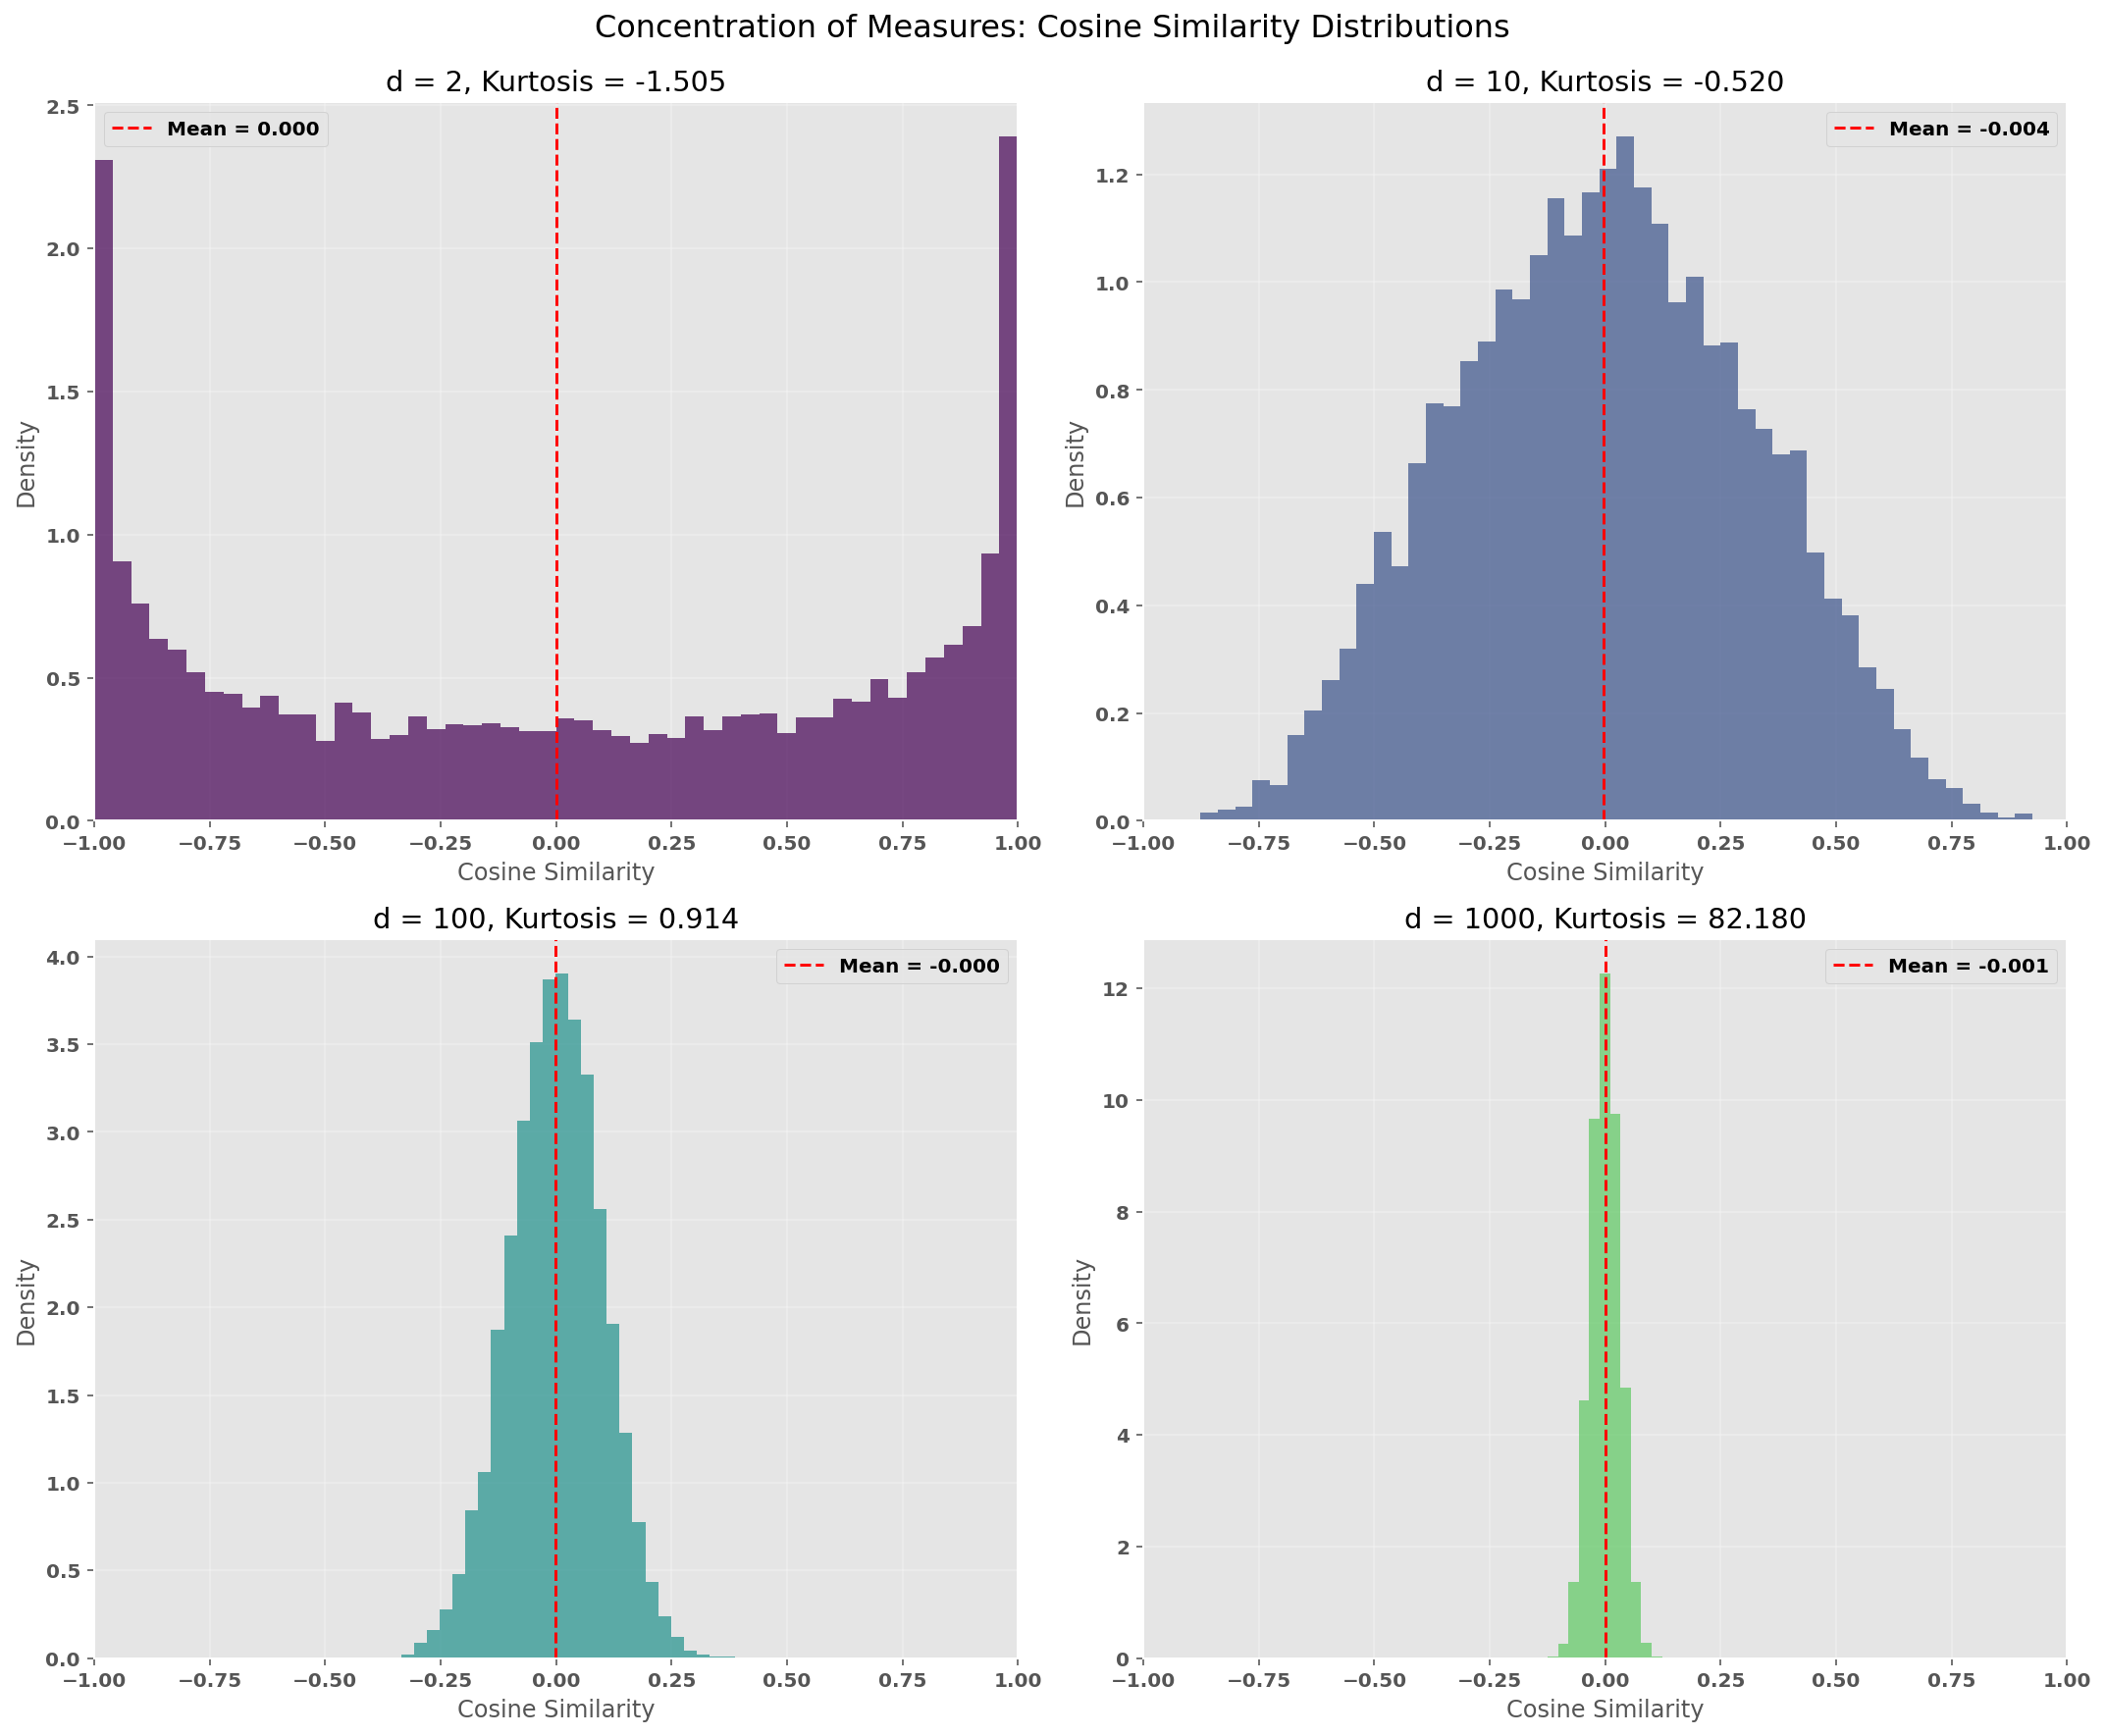


Summary of Kurtosis Values:
------------------------------
d =    2: Kurtosis =   -1.505
d =   10: Kurtosis =   -0.520
d =  100: Kurtosis =    0.914
d = 1000: Kurtosis =   82.180

Note: As dimensionality increases, the distribution becomes more concentrated
around 0, demonstrating the concentration of measures phenomenon.


In [7]:
main()

## Experiment 2

For the same sequence of dimensions, we sample points as follows:

- Uniformly a reference point from the unit ball in $d$ dimensions (ie with boundary at $S^{d-1}$)
- Uniformly $N$ other points also from the same unit ball.


We now compute, relative to the reference point:

- the minimum distance to any other point,
- the maximum distance to any other point,
- the ratio $(dmax − dmin)/dmin$.

In [ ]:
# Experiment 2: Distance concentration in hypercube vs hypersphere
np.random.seed(42)

dimensionalities = [2, 10, 100, 1000]
n_points = 10000

### Why use `np.random.rand(n_points, 1) ** (1.0 / d)` for radii?

To sample points **uniformly in volume** inside a d-dimensional unit ball, the radius must follow the correct distribution. The volume of a ball grows like `r^d`, so the CDF of the radius is:

`P(R <= r) = r^d`.

Using inverse-transform sampling with `U ~ Uniform(0, 1)` gives:

`R = U^(1/d)`.

That is why we raise a uniform random number to the power `1/d`: it produces the correct radial distribution so points are uniform in the ball, not overly concentrated near the center.

Solid sphere (ball) with boundary S^{d-1}
----------------------------------------
d =    2: dmin =   0.0115, dmax =   1.9973, ratio = 172.2436
d =   10: dmin =   0.3159, dmax =   1.8928, ratio =   4.9927
d =  100: dmin =   1.1225, dmax =   1.6344, ratio =   0.4561
d = 1000: dmin =   1.3237, dmax =   1.4967, ratio =   0.1307


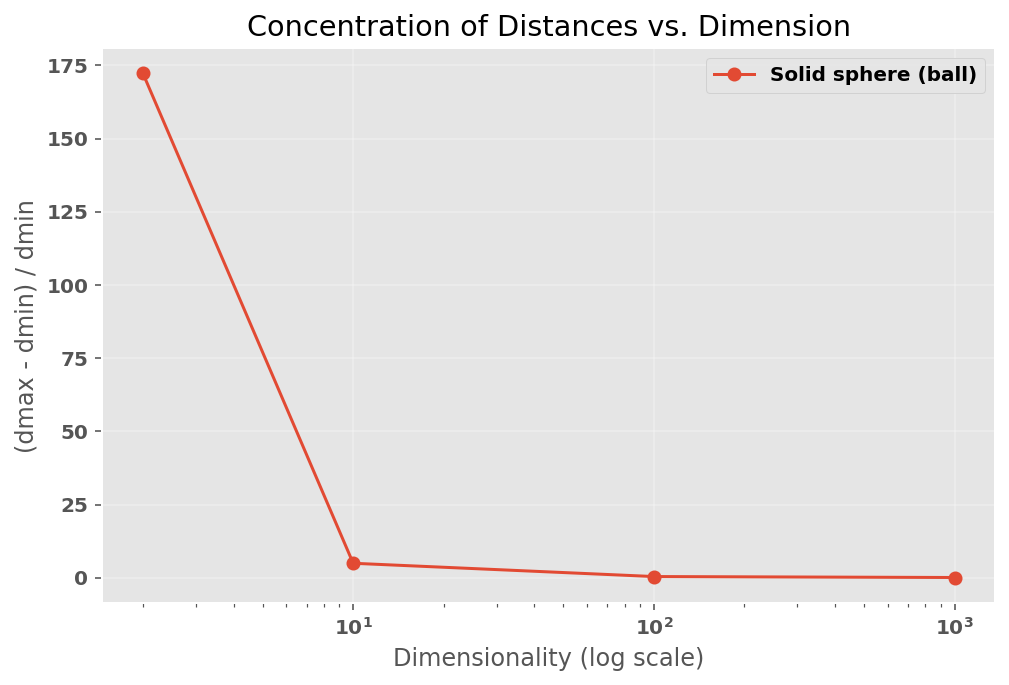

In [ ]:
def sample_hypersphere(n_points, d):
    """Sample uniformly from the unit solid sphere (ball) with boundary S^{d-1}."""
    vectors = np.random.randn(n_points, d)
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    directions = vectors / norms
    radii = np.random.rand(n_points, 1) ** (1.0 / d)
    return directions * radii


def sample_solid_ball_point(d):
    """Sample a single point uniformly from the unit solid sphere (ball)."""
    vector = np.random.randn(1, d)
    norm = np.linalg.norm(vector, axis=1, keepdims=True)
    direction = vector / norm
    radius = np.random.rand(1, 1) ** (1.0 / d)
    return (direction * radius).reshape(-1)


def distance_stats(points, reference_point):
    """Compute dmin, dmax, and (dmax - dmin) / dmin from a reference point."""
    dists = np.linalg.norm(points - reference_point, axis=1)
    dmin = dists.min()
    dmax = dists.max()
    ratio = (dmax - dmin) / dmin
    return dmin, dmax, ratio


results = {}

for d in dimensionalities:
    sphere_points = sample_hypersphere(n_points, d)
    reference_point = sample_solid_ball_point(d)

    results[d] = distance_stats(sphere_points, reference_point=reference_point)


print("Solid sphere (ball) with boundary S^{d-1}")
print("-" * 40)
for d in dimensionalities:
    dmin, dmax, ratio = results[d]
    print(f"d = {d:4d}: dmin = {dmin:8.4f}, dmax = {dmax:8.4f}, ratio = {ratio:8.4f}")


# Plot ratio vs. dimension
sphere_ratios = [results[d][2] for d in dimensionalities]

plt.figure(figsize=(8, 5))
plt.plot(dimensionalities, sphere_ratios, marker="o", label="Solid sphere (ball)")
plt.xscale("log")
plt.xlabel("Dimensionality (log scale)")
plt.ylabel("(dmax - dmin) / dmin")
plt.title("Concentration of Distances vs. Dimension")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()